In [1]:
%load_ext autoreload
%autoreload 2

import anndata
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import pickle
import scanpy as sc
import scipy
import seaborn as sns
from sklearn import decomposition
import time
import warnings
import umap
import h5py
from tensorflow.keras import layers
import tensorflow as tf

import sfaira

usr = !echo $USER
base_path = '.'
base_path_out = '.'

grid_search_dir = '.'
datadir = '.'
targetpath = '.'
configpath = '.'
outdir = base_path_out + '/results/'
figdir = outdir+'/figures/'

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.


In [2]:
import sfaira
import sfaira.api
from sfaira.estimators.keras import EstimatorKerasEmbedding, EstimatorKerasCelltype
from sfaira.versions import celltype_versions

In [3]:
sc.logging.print_version_and_date()
sc.settings.verbosity = 0

%config InlineBackend.figure_formats = ['retina']
sc.settings.verbosity = 3                
sc.settings.n_jobs = 40
sc.settings.set_figure_params(dpi=200, dpi_save=300)

Running Scanpy 1.7.2, on 2021-05-21 14:01.


# Helper functions

In [4]:
from typing import Union
from sfaira.data import load_store
from sfaira.interface import ModelZoo

subsample_to_max = 10000

def get_gradients_by_celltype(
        resultspath,
        model_id,
        datapath,
        configpath: Union[None, str] = None,
        store_format: Union[None, str] = None,
        ignore_cache=False,
        min_cells=10,
):
    print('Compute gradients (1/3): load data')
    # load data
    store = load_store(cache_path=datapath, store_format=store_format)
    store.load_config(configpath)
    store.subset(attr_key="id", values=[k for k in store.indices.keys()
                                        if 'cell_ontology_id' in store.adata_by_key[k].obs.columns])
    store.subset(attr_key="cellontology_class", excluded_values=[
        store._adata_ids_sfaira.unknown_celltype_identifier,
        store._adata_ids_sfaira.not_a_cell_celltype_identifier,
    ])

    print('Compute gradients (2/3): load embedding')
    adatas = store.adata_sliced
    # Load into memory:
    for k in adatas.keys():
        adatas[k] = adatas[k].to_memory()
    adata = adatas[list(adatas.keys())[0]]
    if len(adatas.keys()) > 0:
        adata = adata.concatenate(*[adatas[k] for k in list(adatas.keys())[1:]])
    # Subsample adata object:
    adata = adata[np.random.choice(a=np.arange(0, adata.n_obs), size=np.minimum(subsample_to_max, adata.n_obs), replace=False,), :].copy()
    zoo = ModelZoo()
    zoo.model_id = "_".join(model_id.split("_")[:3])
    embedding = EstimatorKerasEmbedding(
        data=adata,
        model_dir="",
        model_id=model_id,
        model_topology=zoo.topology_container
    )
    embedding.init_model()
    embedding.model.training_model.load_weights(os.path.join(resultspath, f'{model_id}_best_hyperparam_weights.h5'))

    # compute gradients
    print('Compute gradients (3/3): cumulate gradients')
    gradients_raw = embedding.compute_gradients_input(test_data=None, batch_size=256, per_celltype=True)
    
    # filter by minimum number cells min_cells
    filtered_grads = {}
    celltypes = []
    for celltype in gradients_raw['gradients'].keys():
        if gradients_raw['counts'][celltype] > min_cells:
            filtered_grads.update({celltype: gradients_raw['gradients'][celltype]})
            celltypes.append(celltype)

    return np.concatenate([
        np.mean(a, axis=0, keepdims=True)
        for a in list(filtered_grads.values())
    ], axis=0), celltypes

def plot_gradient_distr(
        resultspath,
        model_id,
        datapath,
        configpath: Union[None, str] = None,
        store_format: Union[None, str] = None,
        normalize=True,
        remove_inactive=True,
        min_cells=10,
        bw=0.02,
        xlim=None,
        by_type=True,
        height_fig=7,
        width_fig=7,
        hist=False,
        ignore_cache=False,
        save=None,
):
    # best model for each organ and model_type
    avg_grads, celltypes = get_gradients_by_celltype(
        resultspath=resultspath,
        model_id=model_id,
        datapath=datapath,
        configpath=configpath,
        store_format=store_format,
        ignore_cache=ignore_cache,
        min_cells=min_cells,
    )

    if normalize:
        avg_grads = np.abs(avg_grads)
        avg_grads = (avg_grads - np.min(avg_grads, axis=1, keepdims=True)) /\
            np.maximum(np.max(avg_grads, axis=1, keepdims=True) -
                       np.min(avg_grads, axis=1, keepdims=True), 1e-8)

    fig, axs = plt.subplots(1, 1, figsize=(width_fig, height_fig))

    threshold = np.mean(avg_grads) * 0.05
    avg_grads_mask = np.mean(avg_grads, axis=0) > threshold
    active_grads = avg_grads[:, avg_grads_mask]
    plt.axvline(threshold, color='k', linestyle='dashed', linewidth=1,
                label="active gene threshold"
                )
    plt.axvline(np.mean(active_grads), color='k', linestyle='solid', linewidth=1,
                label="average gradient\nof active genes")
    print('number of active inputs: ', active_grads.shape[1])

    v = avg_grads.copy()
    if by_type:
        v_mask = np.mean(v, axis=0) > threshold
        for i, x in enumerate(v):
            if remove_inactive:
                x = x[v_mask]
            if not hist:
                sns.kdeplot(x, bw_method=bw, ax=axs)
    else:
        if remove_inactive:
            threshold = np.mean(v) * 0.05
            v_mask = np.mean(v, axis=0) > threshold
            v = v[:, v_mask]
        if not hist:
            sns.kdeplot(np.asarray(v).flatten(), bw_method=bw, label=k, ax=axs)

    if xlim is not None:
        axs.set_xlim(xlim)
    plt.legend(loc="best")
    plt.xlabel(r'$\rm{mean}_{i=1,...,D} \frac{\partial z_i}{\partial x}$')
    if hist:
        plt.ylabel('# genes')
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

def plot_gradient_cor(
        resultspath,
        model_id,
        datapath,
        configpath: Union[None, str] = None,
        store_format: Union[None, str] = None,
        height_fig=7,
        width_fig=7,
        ignore_cache=False,
        min_cells=10,
        by_type=True,
        vmin=0.,
        vmax=1.,
        save=None,
):
    # best model for each organ and model_type
    avg_grads, celltypes = get_gradients_by_celltype(
        resultspath=resultspath,
        model_id=model_id,
        datapath=datapath,
        configpath=configpath,
        store_format=store_format,
        ignore_cache=ignore_cache,
        min_cells=min_cells,
    )

    fig, axs = plt.subplots(1, 1, figsize=(width_fig, height_fig))
    if by_type:
        v = avg_grads.copy()
        celltypes_coord = celltypes
        cormat = pandas.DataFrame(
            np.corrcoef(v),
            index=celltypes_coord,
            columns=celltypes_coord
        )
        sns.heatmap(cormat, vmin=vmin, vmax=vmax, ax=axs)
    else:
        pass

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

In [5]:
dir_human_embedding = "/storage/groups/ml01/projects/2021_sfaira_david.fischer/202105_submission/final_training/HUMAN/EMBEDDING/210509_AE_0.1_0.1_CV+210509_AE_0.2_0.1_CV+210509_AE_0.3_0.1_CV/results/"
dir_human_embedding_linear = "/storage/groups/ml01/projects/2021_sfaira_david.fischer/202105_submission/final_training/HUMAN/EMBEDDING/210512_LINEAR_0.1_0.1_CV+210512_LINEAR_0.2_0.1_CV/results/"

# Human kidney

## Gradient correlation

In [6]:
plot_gradient_cor(
    resultspath=dir_human_embedding,
    model_id="embedding_human-kidney-ae-0.3-0.1_theislab",
    height_fig=20,
    width_fig=25,
    ignore_cache=False,
    min_cells = 10,
    by_type=True,
    datapath=datadir,
    store_format="h5ad",
    configpath=os.path.join(configpath, "config_human_kidney.pickle"),
    save=figdir+"gradients_human_kidney_ae_cor.pdf"
)

Compute gradients (1/3): load data
Discovered mouse_placenta_2018_microwellseq_han_052.h5ad as .h5ad file.
Discovered mouse_thymus_2019_10xsequencing_pisco_034.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_10xsequencing_pisco_026.h5ad as .h5ad file.
Discovered human_colonicepithelium_2019_10xsequencing_smilie_001.h5ad as .h5ad file.
Discovered human_testis_2018_10xsequencing_guo_001.h5ad as .h5ad file.
Discovered mouse_heart_2019_10xsequencing_pisco_015.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_005.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_048.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_001.h5ad as .h5ad file.
Discovered mouse_intestine_2018_microwellseq_han_010.h5ad as .h5ad file.
Discovered mouse_brain_2018_microwellseq_han_006.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_050.h5ad as .h5ad file.
Discovered human_placenta_2018_smartseq2_ventotormo_002.h5ad as .h5ad file.
Discov

Discovered mouse_bonemarrow_2019_10xsequencing_pisco_008.h5ad as .h5ad file.
Discovered mouse_prostategland_2018_microwellseq_han_055.h5ad as .h5ad file.
Discovered mouse_testis_2018_microwellseq_han_064.h5ad as .h5ad file.
Discovered human_retina_2019_10xsequencing_voigt_001.h5ad as .h5ad file.
Discovered mouse_kidney_2019_smartseq2_pisco_019.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_002.h5ad as .h5ad file.
Discovered human_lung_2020_10xsequencing_miller_001.h5ad as .h5ad file.
Discovered human_blood_2019_10xsequencing_szabo_013.h5ad as .h5ad file.
Discovered human_rectum_2019_10xsequencing_wang_003.h5ad as .h5ad file.
Discovered mouse_lung_2018_microwellseq_han_014.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_002.h5ad as .h5ad file.
Discovered human_lung_2019_10xsequencing_szabo_008.h5ad as .h5ad file.
Discovered mouse_brain_2019_smartseq2_pisco_010.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_smartseq2_pisco_027.h5ad 

matched keys ['CNS neuron (sensu Vertebrata)', 'Purkinje cell', 'Schwann cell', 'acinar cell', 'amacrine cell', 'astrocyte', 'bipolar neuron', 'brush cell', 'cardiac muscle cell', 'cell of skeletal muscle', 'chromaffin cell', 'ciliated epithelial cell', 'cortical cell of adrenal gland', 'endocardial cell', 'endocrine cell', 'endothelial cell of lymphatic vessel', 'endothelial cell of vascular tree', 'enteric neuron', 'epicardial adipocyte', 'epithelial cell', 'epithelial cell of thymus', 'erythroblast', 'excitatory neuron', 'extravillous trophoblast', 'glial cell', 'goblet cell', 'granule cell', 'hematopoietic stem cell', 'hepatic stellate cell', 'hepatoblast', 'inhibitory interneuron', 'inhibitory neuron', 'innate lymphoid cell', 'intestinal epithelial cell', 'kidney cell', 'lens fiber cell', 'megakaryocyte', 'mesangial cell', 'mesothelial cell', 'microglial cell', 'myeloid cell', 'neural progenitor cell', 'neuroendocrine cell', 'neuron of cerebral cortex', 'oligodendrocyte', 'pancrea

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.
passed hyperpar: 
 {'latent_dim': (512, 256, 128, 256, 512), 'l1_coef': 0.0, 'l2_coef': 0.0, 'dropout_rate': 0.0, 'input_dropout': 0.0, 'batchnorm': True, 'activation': 'selu', 'init': 'lecun_normal', 'output_layer': 'nb_shared_disp'}
Compute gradients (3/3): cumulate gradients


  0%|          | 0/40.0 [00:00<?, ?it/s]

found 19973 intersecting features between 19973 features in input data set and 19973 features in reference genome
found 10000 observations


100%|██████████| 40/40.0 [11:21<00:00, 17.03s/it]


B cell with 59 observations
CD4-positive, alpha-beta T cell with 118 observations
CD8-positive, alpha-beta T cell with 38 observations
T cell with 29 observations
basal cell with 82 observations
classical monocyte with 14 observations
conventional dendritic cell with 40 observations
cortical cell of adrenal gland with 1 observations
dendritic cell with 22 observations
endothelial cell with 146 observations
endothelial cell of vascular tree with 239 observations
epithelial cell with 82 observations
epithelial cell of distal tubule with 65 observations
epithelial cell of proximal tubule with 1412 observations
erythroblast with 8 observations
erythroid lineage cell with 3 observations
fenestrated cell with 73 observations
fibroblast with 41 observations
glomerular capillary endothelial cell with 32 observations
glomerular endothelial cell with 11 observations
glomerular visceral epithelial cell with 73 observations
innate lymphoid cell with 24 observations
kidney blood vessel cell with 68

## Gradient histogram

Compute gradients (1/3): load data
Discovered mouse_placenta_2018_microwellseq_han_052.h5ad as .h5ad file.
Discovered mouse_thymus_2019_10xsequencing_pisco_034.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_10xsequencing_pisco_026.h5ad as .h5ad file.
Discovered human_colonicepithelium_2019_10xsequencing_smilie_001.h5ad as .h5ad file.
Discovered human_testis_2018_10xsequencing_guo_001.h5ad as .h5ad file.
Discovered mouse_heart_2019_10xsequencing_pisco_015.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_005.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_048.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_001.h5ad as .h5ad file.
Discovered mouse_intestine_2018_microwellseq_han_010.h5ad as .h5ad file.
Discovered mouse_brain_2018_microwellseq_han_006.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_050.h5ad as .h5ad file.
Discovered human_placenta_2018_smartseq2_ventotormo_002.h5ad as .h5ad file.
Discov

Discovered mouse_bonemarrow_2019_10xsequencing_pisco_008.h5ad as .h5ad file.
Discovered mouse_prostategland_2018_microwellseq_han_055.h5ad as .h5ad file.
Discovered mouse_testis_2018_microwellseq_han_064.h5ad as .h5ad file.
Discovered human_retina_2019_10xsequencing_voigt_001.h5ad as .h5ad file.
Discovered mouse_kidney_2019_smartseq2_pisco_019.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_002.h5ad as .h5ad file.
Discovered human_lung_2020_10xsequencing_miller_001.h5ad as .h5ad file.
Discovered human_blood_2019_10xsequencing_szabo_013.h5ad as .h5ad file.
Discovered human_rectum_2019_10xsequencing_wang_003.h5ad as .h5ad file.
Discovered mouse_lung_2018_microwellseq_han_014.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_002.h5ad as .h5ad file.
Discovered human_lung_2019_10xsequencing_szabo_008.h5ad as .h5ad file.
Discovered mouse_brain_2019_smartseq2_pisco_010.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_smartseq2_pisco_027.h5ad 

matched keys ['CNS neuron (sensu Vertebrata)', 'Purkinje cell', 'Schwann cell', 'acinar cell', 'amacrine cell', 'astrocyte', 'bipolar neuron', 'brush cell', 'cardiac muscle cell', 'cell of skeletal muscle', 'chromaffin cell', 'ciliated epithelial cell', 'cortical cell of adrenal gland', 'endocardial cell', 'endocrine cell', 'endothelial cell of lymphatic vessel', 'endothelial cell of vascular tree', 'enteric neuron', 'epicardial adipocyte', 'epithelial cell', 'epithelial cell of thymus', 'erythroblast', 'excitatory neuron', 'extravillous trophoblast', 'glial cell', 'goblet cell', 'granule cell', 'hematopoietic stem cell', 'hepatic stellate cell', 'hepatoblast', 'inhibitory interneuron', 'inhibitory neuron', 'innate lymphoid cell', 'intestinal epithelial cell', 'kidney cell', 'lens fiber cell', 'megakaryocyte', 'mesangial cell', 'mesothelial cell', 'microglial cell', 'myeloid cell', 'neural progenitor cell', 'neuroendocrine cell', 'neuron of cerebral cortex', 'oligodendrocyte', 'pancrea

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.
passed hyperpar: 
 {'latent_dim': (512, 256, 128, 256, 512), 'l1_coef': 0.0, 'l2_coef': 0.0, 'dropout_rate': 0.0, 'input_dropout': 0.0, 'batchnorm': True, 'activation': 'selu', 'init': 'lecun_normal', 'output_layer': 'nb_shared_disp'}
Compute gradients (3/3): cumulate gradients
found 19973 intersecting features between 19973 features in input data set and 19973 features in reference genome
found 10000 observations


100%|██████████| 40/40.0 [14:12<00:00, 21.31s/it]


B cell with 55 observations
CD4-positive, alpha-beta T cell with 99 observations
CD8-positive, alpha-beta T cell with 43 observations
T cell with 23 observations
basal cell with 70 observations
classical monocyte with 25 observations
conventional dendritic cell with 45 observations
dendritic cell with 19 observations
endothelial cell with 118 observations
endothelial cell of vascular tree with 201 observations
epithelial cell with 67 observations
epithelial cell of distal tubule with 59 observations
epithelial cell of proximal tubule with 1441 observations
erythroblast with 13 observations
erythrocyte with 2 observations
erythroid lineage cell with 1 observations
fenestrated cell with 58 observations
fibroblast with 40 observations
glomerular capillary endothelial cell with 33 observations
glomerular endothelial cell with 19 observations
glomerular visceral epithelial cell with 65 observations
innate lymphoid cell with 28 observations
kidney blood vessel cell with 59 observations
kidne

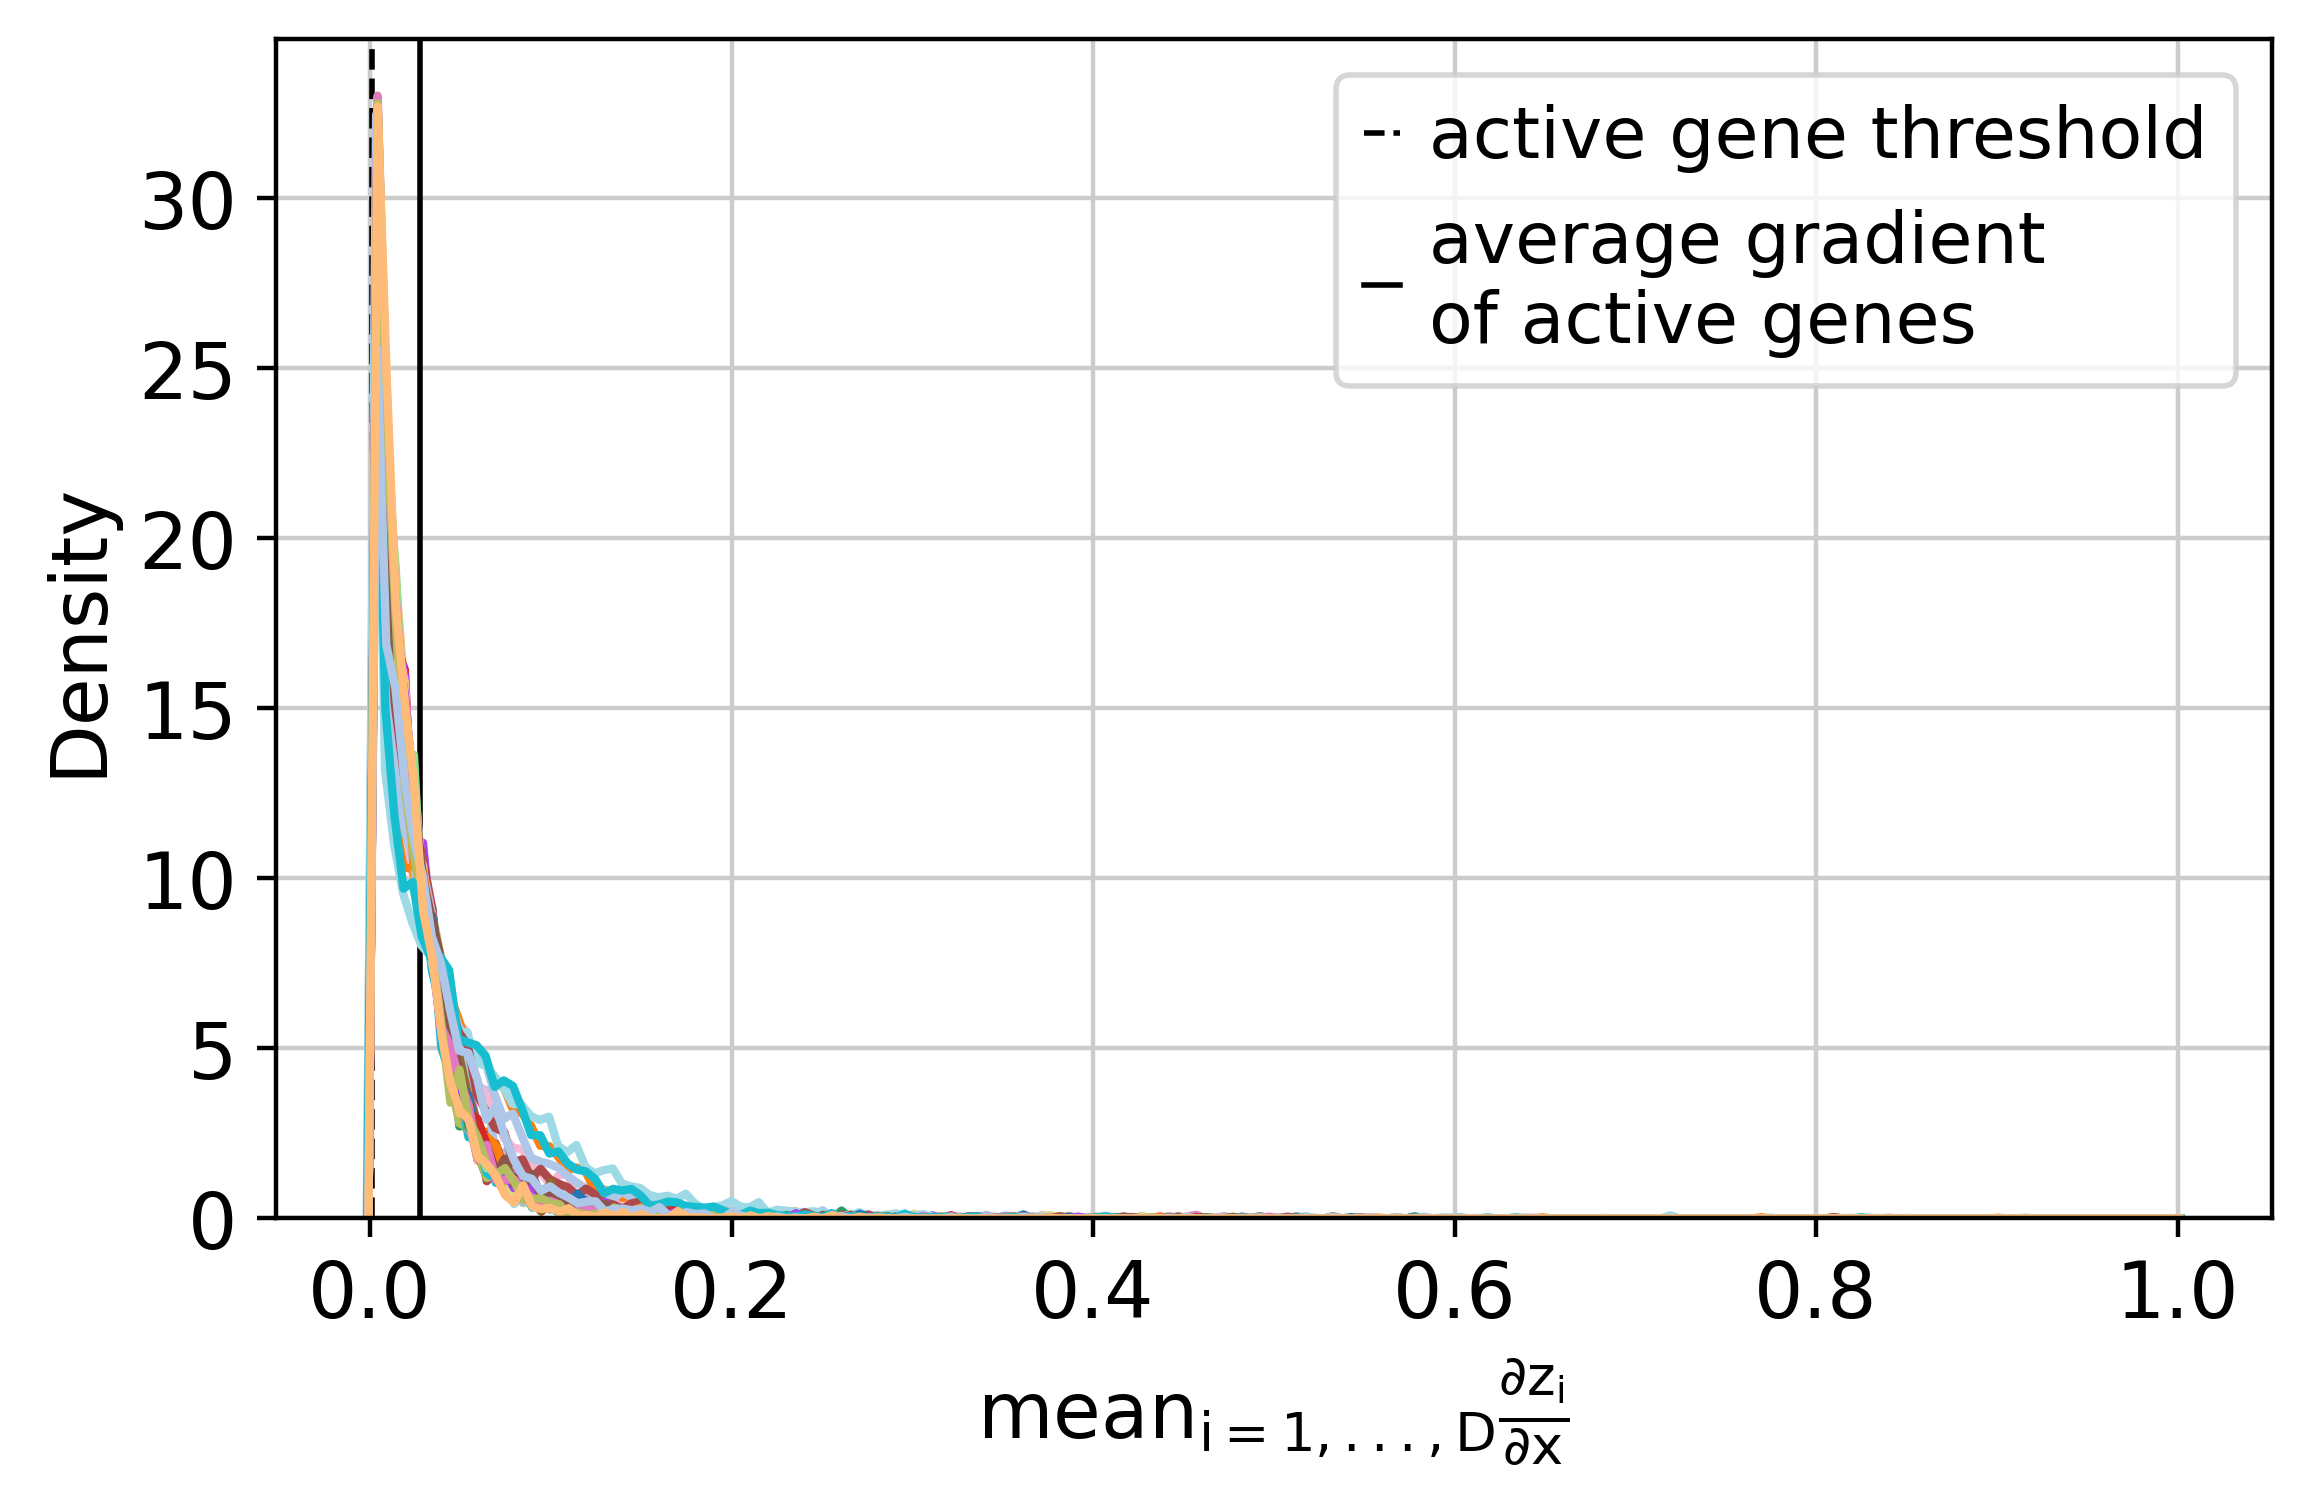

In [7]:
plot_gradient_distr(
    resultspath=dir_human_embedding,
    model_id="embedding_human-kidney-ae-0.3-0.1_theislab",
    height_fig=4,
    width_fig=6,
    ignore_cache=False,
    remove_inactive=False,
    normalize=True,
    min_cells = 10,
    bw=0.01,
    by_type=True,
    datapath=datadir,
    store_format="h5ad",
    configpath=os.path.join(configpath, "config_human_kidney.pickle"),
    save=figdir+"gradients_human_kidney_ae_kde.pdf"
)

# Human esophagus

## Gradient correlation

Compute gradients (1/3): load data
Discovered mouse_placenta_2018_microwellseq_han_052.h5ad as .h5ad file.
Discovered mouse_thymus_2019_10xsequencing_pisco_034.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_10xsequencing_pisco_026.h5ad as .h5ad file.
Discovered human_colonicepithelium_2019_10xsequencing_smilie_001.h5ad as .h5ad file.
Discovered human_testis_2018_10xsequencing_guo_001.h5ad as .h5ad file.
Discovered mouse_heart_2019_10xsequencing_pisco_015.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_005.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_048.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_001.h5ad as .h5ad file.
Discovered mouse_intestine_2018_microwellseq_han_010.h5ad as .h5ad file.
Discovered mouse_brain_2018_microwellseq_han_006.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_050.h5ad as .h5ad file.
Discovered human_placenta_2018_smartseq2_ventotormo_002.h5ad as .h5ad file.
Discov

Discovered mouse_bonemarrow_2019_10xsequencing_pisco_008.h5ad as .h5ad file.
Discovered mouse_prostategland_2018_microwellseq_han_055.h5ad as .h5ad file.
Discovered mouse_testis_2018_microwellseq_han_064.h5ad as .h5ad file.
Discovered human_retina_2019_10xsequencing_voigt_001.h5ad as .h5ad file.
Discovered mouse_kidney_2019_smartseq2_pisco_019.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_002.h5ad as .h5ad file.
Discovered human_lung_2020_10xsequencing_miller_001.h5ad as .h5ad file.
Discovered human_blood_2019_10xsequencing_szabo_013.h5ad as .h5ad file.
Discovered human_rectum_2019_10xsequencing_wang_003.h5ad as .h5ad file.
Discovered mouse_lung_2018_microwellseq_han_014.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_002.h5ad as .h5ad file.
Discovered human_lung_2019_10xsequencing_szabo_008.h5ad as .h5ad file.
Discovered mouse_brain_2019_smartseq2_pisco_010.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_smartseq2_pisco_027.h5ad 

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.
passed hyperpar: 
 {'latent_dim': (256, 128, 64, 128, 256), 'l1_coef': 0.0, 'l2_coef': 0.0, 'dropout_rate': 0.0, 'input_dropout': 0.0, 'batchnorm': True, 'activation': 'selu', 'init': 'lecun_normal', 'output_layer': 'nb_shared_disp'}
Compute gradients (3/3): cumulate gradients


  0%|          | 0/40.0 [00:00<?, ?it/s]

found 19973 intersecting features between 19973 features in input data set and 19973 features in reference genome
found 10000 observations


100%|██████████| 40/40.0 [05:50<00:00,  8.76s/it]


B cell with 171 observations
CD4-positive, alpha-beta T cell with 137 observations
CD8-positive, alpha-beta T cell with 72 observations
basal cell with 77 observations
blood vessel endothelial cell with 167 observations
dendritic cell with 28 observations
endothelial cell with 97 observations
endothelial cell of lymphatic vessel with 12 observations
epithelial cell with 3029 observations
epithelial cell of esophagus with 247 observations
epithelial cell of stratum germinativum of esophagus with 5141 observations
fibroblast with 27 observations
glandular cell of esophagus with 21 observations
goblet cell with 27 observations
keratinocyte with 24 observations
macrophage with 71 observations
mast cell with 33 observations
mature NK T cell with 19 observations
mucous cell of stomach with 127 observations
myeloid leukocyte with 30 observations
neutrophil with 29 observations
plasma cell with 6 observations
professional antigen presenting cell with 29 observations
smooth muscle cell with 10 

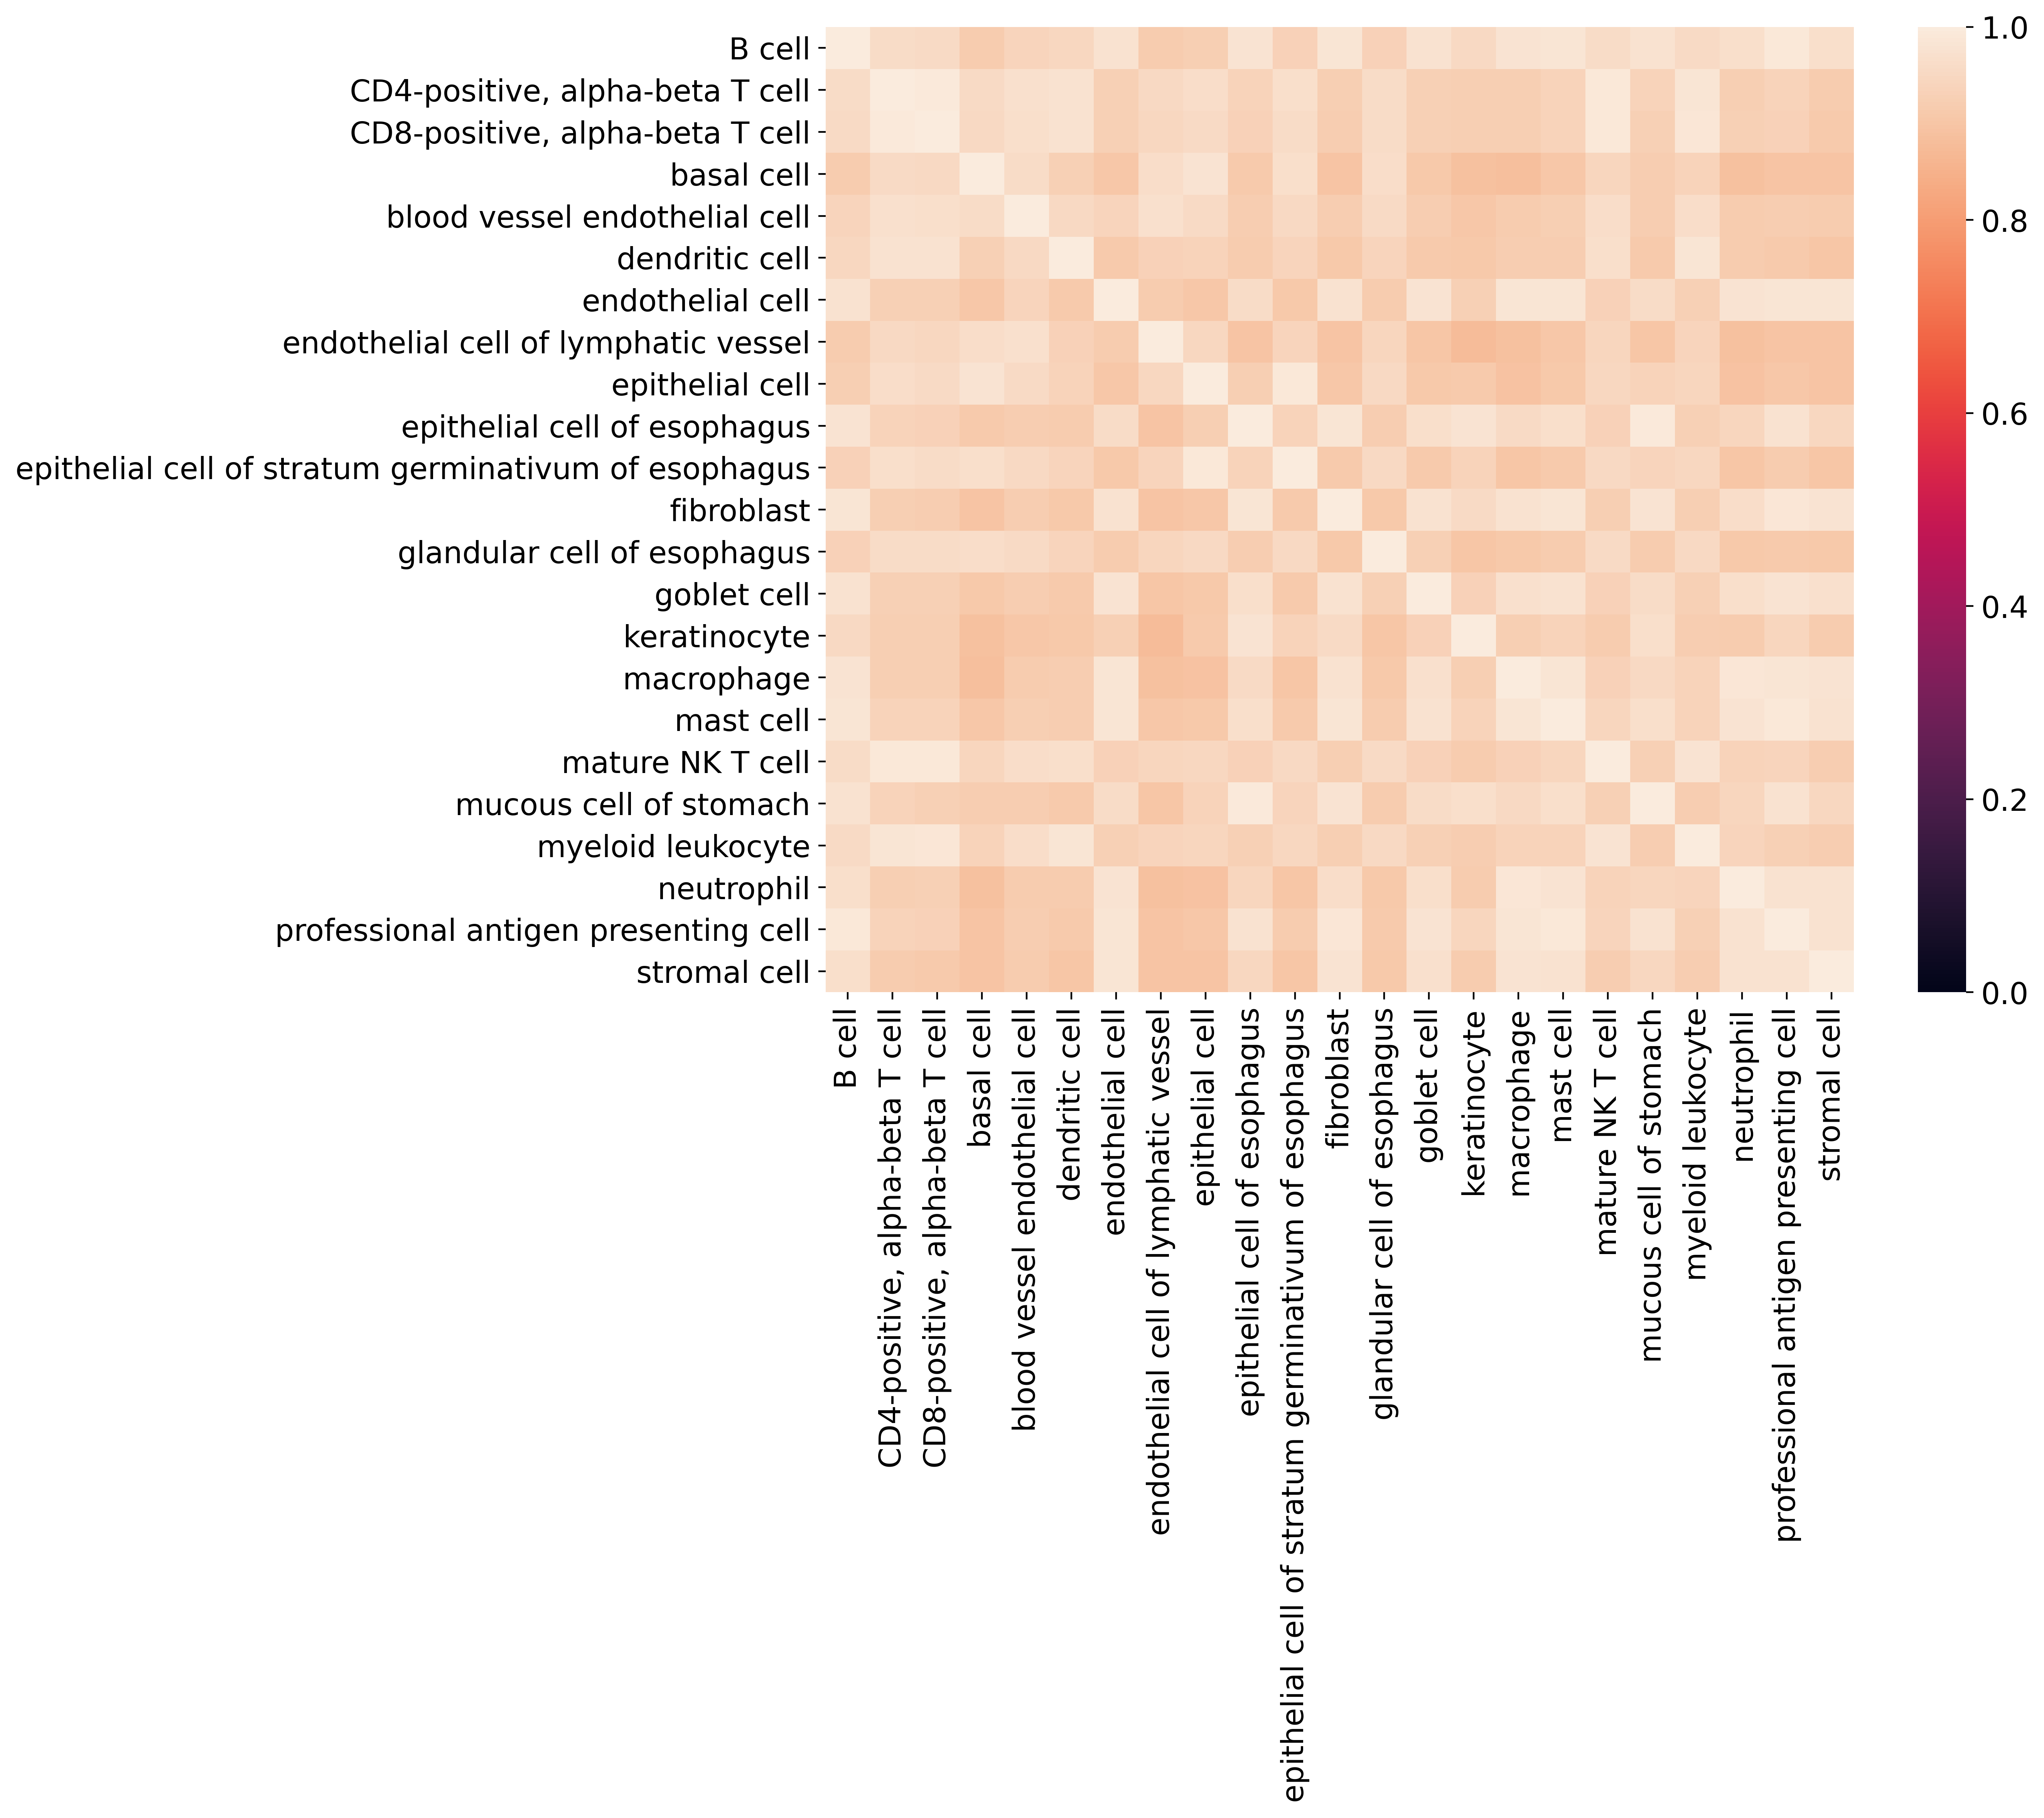

In [8]:
plot_gradient_cor(
    resultspath=dir_human_embedding,
    model_id="embedding_human-esophagus-ae-0.2-0.1_theislab",
    height_fig=12,
    width_fig=14,
    ignore_cache=False,
    min_cells = 10,
    by_type=True,
    datapath=datadir,
    store_format="h5ad",
    configpath=os.path.join(configpath, "config_human_esophagus.pickle"),
    save=figdir+"gradients_human_esophagus_ae_cor.pdf"
)

Compute gradients (1/3): load data
Discovered mouse_placenta_2018_microwellseq_han_052.h5ad as .h5ad file.
Discovered mouse_thymus_2019_10xsequencing_pisco_034.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_10xsequencing_pisco_026.h5ad as .h5ad file.
Discovered human_colonicepithelium_2019_10xsequencing_smilie_001.h5ad as .h5ad file.
Discovered human_testis_2018_10xsequencing_guo_001.h5ad as .h5ad file.
Discovered mouse_heart_2019_10xsequencing_pisco_015.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_005.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_048.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_001.h5ad as .h5ad file.
Discovered mouse_intestine_2018_microwellseq_han_010.h5ad as .h5ad file.
Discovered mouse_brain_2018_microwellseq_han_006.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_050.h5ad as .h5ad file.
Discovered human_placenta_2018_smartseq2_ventotormo_002.h5ad as .h5ad file.
Discov

Discovered mouse_bonemarrow_2019_10xsequencing_pisco_008.h5ad as .h5ad file.
Discovered mouse_prostategland_2018_microwellseq_han_055.h5ad as .h5ad file.
Discovered mouse_testis_2018_microwellseq_han_064.h5ad as .h5ad file.
Discovered human_retina_2019_10xsequencing_voigt_001.h5ad as .h5ad file.
Discovered mouse_kidney_2019_smartseq2_pisco_019.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_002.h5ad as .h5ad file.
Discovered human_lung_2020_10xsequencing_miller_001.h5ad as .h5ad file.
Discovered human_blood_2019_10xsequencing_szabo_013.h5ad as .h5ad file.
Discovered human_rectum_2019_10xsequencing_wang_003.h5ad as .h5ad file.
Discovered mouse_lung_2018_microwellseq_han_014.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_002.h5ad as .h5ad file.
Discovered human_lung_2019_10xsequencing_szabo_008.h5ad as .h5ad file.
Discovered mouse_brain_2019_smartseq2_pisco_010.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_smartseq2_pisco_027.h5ad 

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.
passed hyperpar: 
 {'latent_dim': 64, 'l1_coef': 0.0, 'l2_coef': 0.0, 'positive_components': False, 'output_layer': 'nb_shared_disp'}
Compute gradients (3/3): cumulate gradients


  0%|          | 0/40.0 [00:00<?, ?it/s]

found 19973 intersecting features between 19973 features in input data set and 19973 features in reference genome
found 10000 observations


100%|██████████| 40/40.0 [05:03<00:00,  7.59s/it]


B cell with 178 observations
CD4-positive, alpha-beta T cell with 141 observations
CD8-positive, alpha-beta T cell with 78 observations
basal cell with 76 observations
blood vessel endothelial cell with 149 observations
dendritic cell with 31 observations
endothelial cell with 103 observations
endothelial cell of lymphatic vessel with 8 observations
epithelial cell with 2979 observations
epithelial cell of esophagus with 226 observations
epithelial cell of stratum germinativum of esophagus with 5190 observations
fibroblast with 24 observations
glandular cell of esophagus with 18 observations
goblet cell with 21 observations
keratinocyte with 16 observations
macrophage with 69 observations
mast cell with 30 observations
mature NK T cell with 22 observations
mucous cell of stomach with 172 observations
myeloid leukocyte with 33 observations
neutrophil with 23 observations
plasma cell with 9 observations
professional antigen presenting cell with 29 observations
smooth muscle cell with 5 o

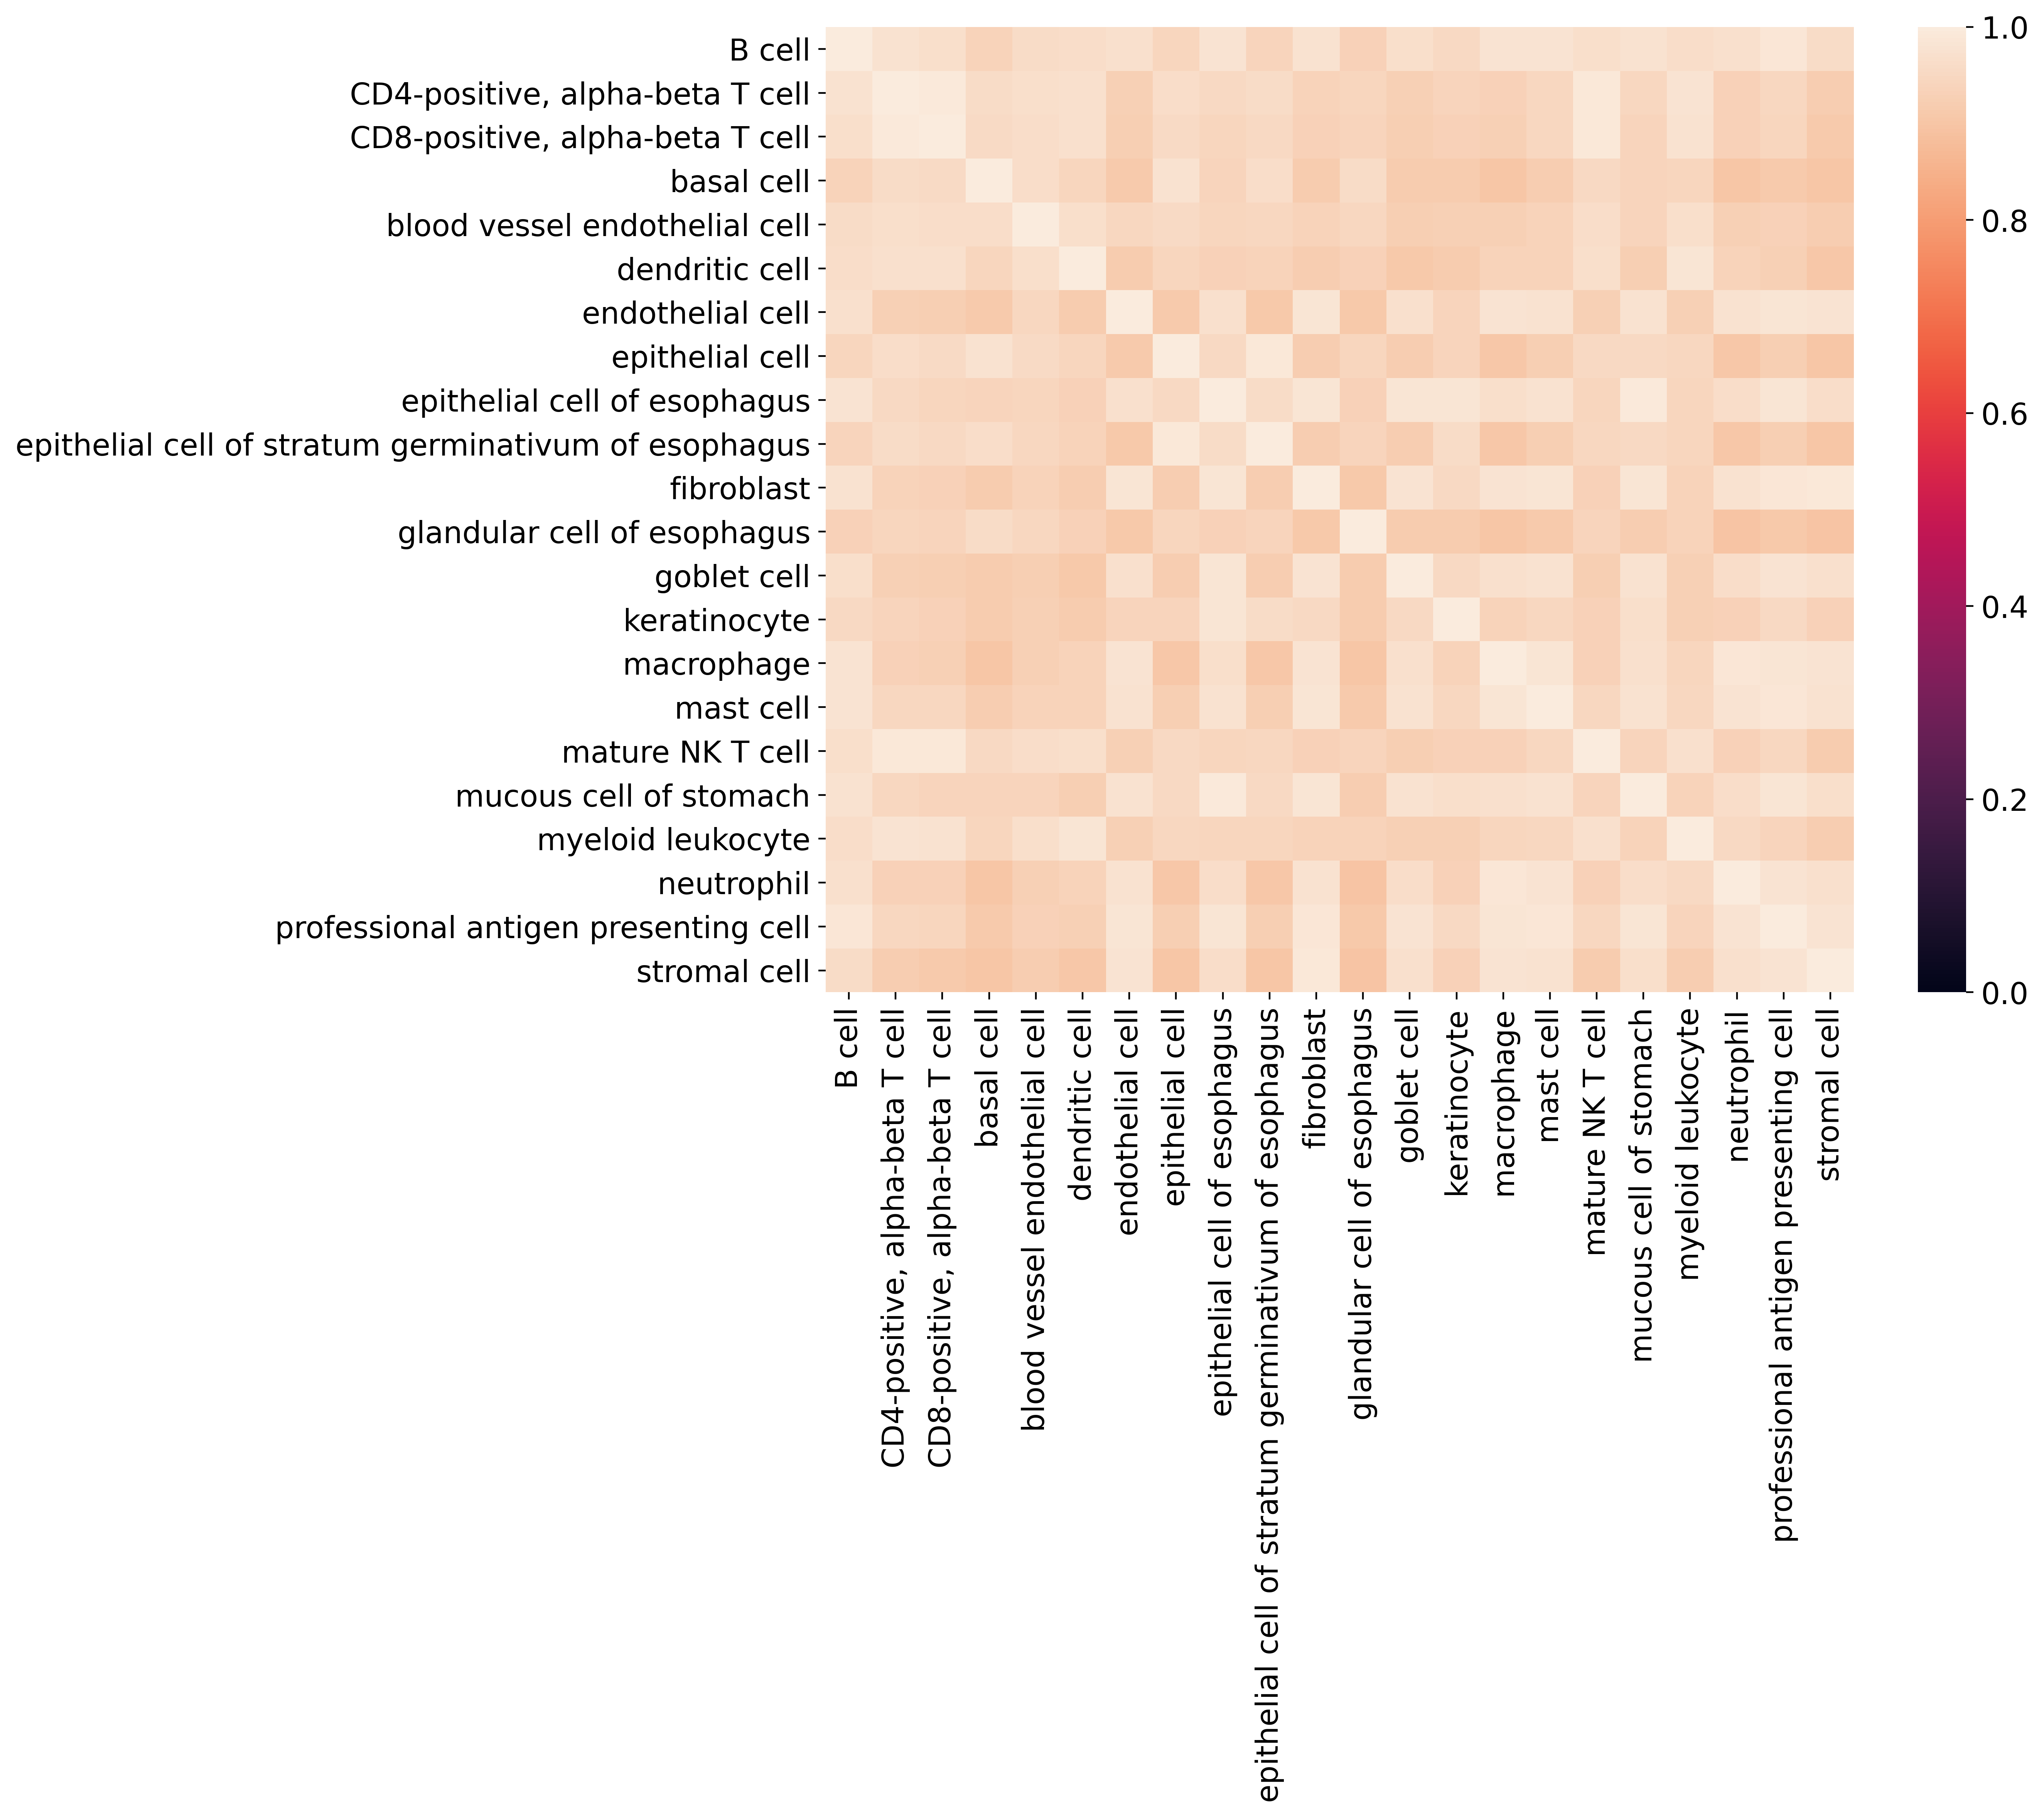

In [9]:
plot_gradient_cor(
    resultspath=dir_human_embedding_linear,
    model_id="embedding_human-esophagus-linear-0.1-0.1_theislab",
    height_fig=12,
    width_fig=14,
    ignore_cache=False,
    min_cells = 10,
    by_type=True,
    datapath=datadir,
    store_format="h5ad",
    configpath=os.path.join(configpath, "config_human_esophagus.pickle"),
    save=figdir+"gradients_human_esophagus_linear_cor.pdf",
)

## Gradient histogram

Compute gradients (1/3): load data
Discovered mouse_placenta_2018_microwellseq_han_052.h5ad as .h5ad file.
Discovered mouse_thymus_2019_10xsequencing_pisco_034.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_10xsequencing_pisco_026.h5ad as .h5ad file.
Discovered human_colonicepithelium_2019_10xsequencing_smilie_001.h5ad as .h5ad file.
Discovered human_testis_2018_10xsequencing_guo_001.h5ad as .h5ad file.
Discovered mouse_heart_2019_10xsequencing_pisco_015.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_005.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_048.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_001.h5ad as .h5ad file.
Discovered mouse_intestine_2018_microwellseq_han_010.h5ad as .h5ad file.
Discovered mouse_brain_2018_microwellseq_han_006.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_050.h5ad as .h5ad file.
Discovered human_placenta_2018_smartseq2_ventotormo_002.h5ad as .h5ad file.
Discov

Discovered mouse_bonemarrow_2019_10xsequencing_pisco_008.h5ad as .h5ad file.
Discovered mouse_prostategland_2018_microwellseq_han_055.h5ad as .h5ad file.
Discovered mouse_testis_2018_microwellseq_han_064.h5ad as .h5ad file.
Discovered human_retina_2019_10xsequencing_voigt_001.h5ad as .h5ad file.
Discovered mouse_kidney_2019_smartseq2_pisco_019.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_002.h5ad as .h5ad file.
Discovered human_lung_2020_10xsequencing_miller_001.h5ad as .h5ad file.
Discovered human_blood_2019_10xsequencing_szabo_013.h5ad as .h5ad file.
Discovered human_rectum_2019_10xsequencing_wang_003.h5ad as .h5ad file.
Discovered mouse_lung_2018_microwellseq_han_014.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_002.h5ad as .h5ad file.
Discovered human_lung_2019_10xsequencing_szabo_008.h5ad as .h5ad file.
Discovered mouse_brain_2019_smartseq2_pisco_010.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_smartseq2_pisco_027.h5ad 

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.
passed hyperpar: 
 {'latent_dim': (256, 128, 64, 128, 256), 'l1_coef': 0.0, 'l2_coef': 0.0, 'dropout_rate': 0.0, 'input_dropout': 0.0, 'batchnorm': True, 'activation': 'selu', 'init': 'lecun_normal', 'output_layer': 'nb_shared_disp'}
Compute gradients (3/3): cumulate gradients
found 19973 intersecting features between 19973 features in input data set and 19973 features in reference genome
found 10000 observations


100%|██████████| 40/40.0 [05:40<00:00,  8.52s/it]


B cell with 191 observations
CD4-positive, alpha-beta T cell with 132 observations
CD8-positive, alpha-beta T cell with 79 observations
basal cell with 73 observations
blood vessel endothelial cell with 132 observations
dendritic cell with 40 observations
endothelial cell with 93 observations
endothelial cell of lymphatic vessel with 11 observations
epithelial cell with 3075 observations
epithelial cell of esophagus with 251 observations
epithelial cell of stratum germinativum of esophagus with 5071 observations
fibroblast with 21 observations
glandular cell of esophagus with 16 observations
goblet cell with 20 observations
keratinocyte with 17 observations
macrophage with 70 observations
mast cell with 29 observations
mature NK T cell with 19 observations
mucous cell of stomach with 184 observations
myeloid leukocyte with 41 observations
neutrophil with 25 observations
plasma cell with 2 observations
professional antigen presenting cell with 32 observations
smooth muscle cell with 11 

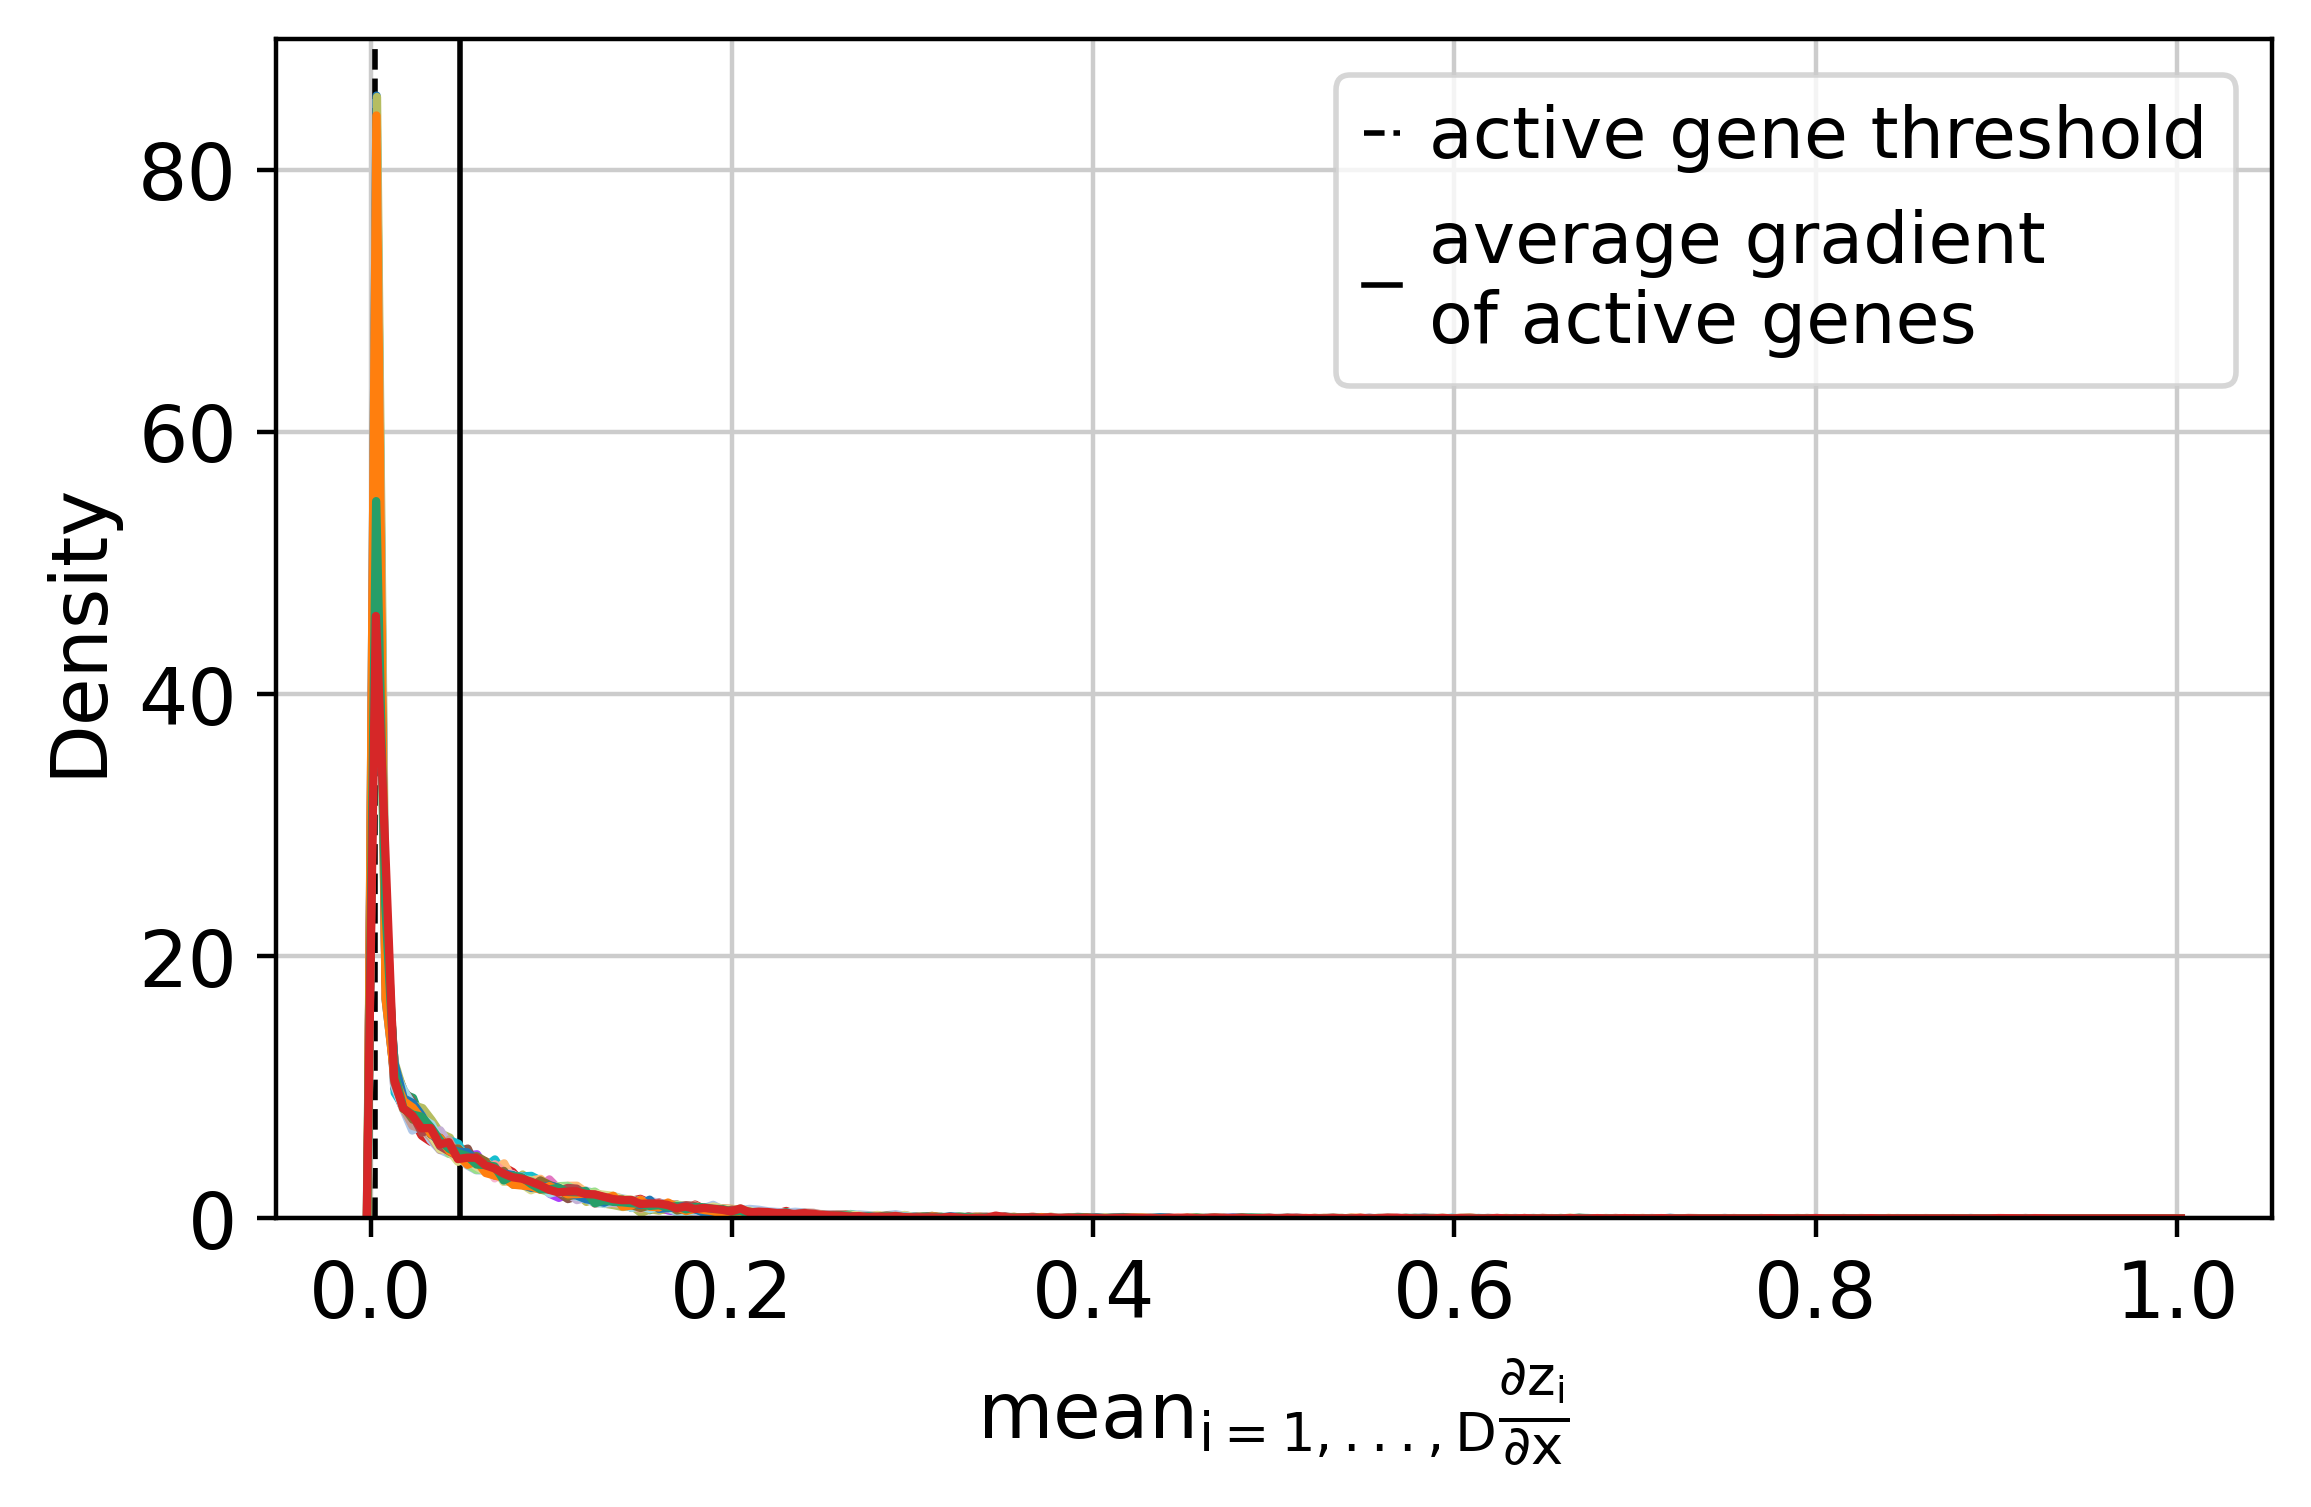

In [10]:
plot_gradient_distr(
    resultspath=dir_human_embedding,
    model_id="embedding_human-esophagus-ae-0.2-0.1_theislab",
    height_fig=4,
    width_fig=6,
    ignore_cache=False,
    remove_inactive=False,
    normalize=True,
    min_cells = 10,
    bw=0.01,
    by_type=True,
    datapath=datadir,
    store_format="h5ad",
    configpath=os.path.join(configpath, "config_human_esophagus.pickle"),
    save=figdir+"gradients_human_esophagus_ae_kde.pdf"
)

Compute gradients (1/3): load data
Discovered mouse_placenta_2018_microwellseq_han_052.h5ad as .h5ad file.
Discovered mouse_thymus_2019_10xsequencing_pisco_034.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_10xsequencing_pisco_026.h5ad as .h5ad file.
Discovered human_colonicepithelium_2019_10xsequencing_smilie_001.h5ad as .h5ad file.
Discovered human_testis_2018_10xsequencing_guo_001.h5ad as .h5ad file.
Discovered mouse_heart_2019_10xsequencing_pisco_015.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_005.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_048.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_001.h5ad as .h5ad file.
Discovered mouse_intestine_2018_microwellseq_han_010.h5ad as .h5ad file.
Discovered mouse_brain_2018_microwellseq_han_006.h5ad as .h5ad file.
Discovered mouse_blood_2018_microwellseq_han_050.h5ad as .h5ad file.
Discovered human_placenta_2018_smartseq2_ventotormo_002.h5ad as .h5ad file.
Discov

Discovered mouse_bonemarrow_2019_10xsequencing_pisco_008.h5ad as .h5ad file.
Discovered mouse_prostategland_2018_microwellseq_han_055.h5ad as .h5ad file.
Discovered mouse_testis_2018_microwellseq_han_064.h5ad as .h5ad file.
Discovered human_retina_2019_10xsequencing_voigt_001.h5ad as .h5ad file.
Discovered mouse_kidney_2019_smartseq2_pisco_019.h5ad as .h5ad file.
Discovered mouse_pancreas_2019_10xsequencing_thompson_002.h5ad as .h5ad file.
Discovered human_lung_2020_10xsequencing_miller_001.h5ad as .h5ad file.
Discovered human_blood_2019_10xsequencing_szabo_013.h5ad as .h5ad file.
Discovered human_rectum_2019_10xsequencing_wang_003.h5ad as .h5ad file.
Discovered mouse_lung_2018_microwellseq_han_014.h5ad as .h5ad file.
Discovered mouse_bonemarrow_2018_microwellseq_han_002.h5ad as .h5ad file.
Discovered human_lung_2019_10xsequencing_szabo_008.h5ad as .h5ad file.
Discovered mouse_brain_2019_smartseq2_pisco_010.h5ad as .h5ad file.
Discovered mouse_muscleorgan_2019_smartseq2_pisco_027.h5ad 

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.
passed hyperpar: 
 {'latent_dim': 64, 'l1_coef': 0.0, 'l2_coef': 0.0, 'positive_components': False, 'output_layer': 'nb_shared_disp'}
Compute gradients (3/3): cumulate gradients


  0%|          | 0/40.0 [00:00<?, ?it/s]

found 19973 intersecting features between 19973 features in input data set and 19973 features in reference genome
found 10000 observations


100%|██████████| 40/40.0 [04:57<00:00,  7.43s/it]


B cell with 169 observations
CD4-positive, alpha-beta T cell with 122 observations
CD8-positive, alpha-beta T cell with 97 observations
basal cell with 85 observations
blood vessel endothelial cell with 164 observations
dendritic cell with 32 observations
endothelial cell with 96 observations
endothelial cell of lymphatic vessel with 11 observations
epithelial cell with 3042 observations
epithelial cell of esophagus with 254 observations
epithelial cell of stratum germinativum of esophagus with 5096 observations
fibroblast with 18 observations
glandular cell of esophagus with 22 observations
goblet cell with 23 observations
keratinocyte with 19 observations
macrophage with 73 observations
mast cell with 30 observations
mature NK T cell with 23 observations
mucous cell of stomach with 163 observations
myeloid leukocyte with 33 observations
neutrophil with 36 observations
plasma cell with 3 observations
professional antigen presenting cell with 30 observations
smooth muscle cell with 3 o

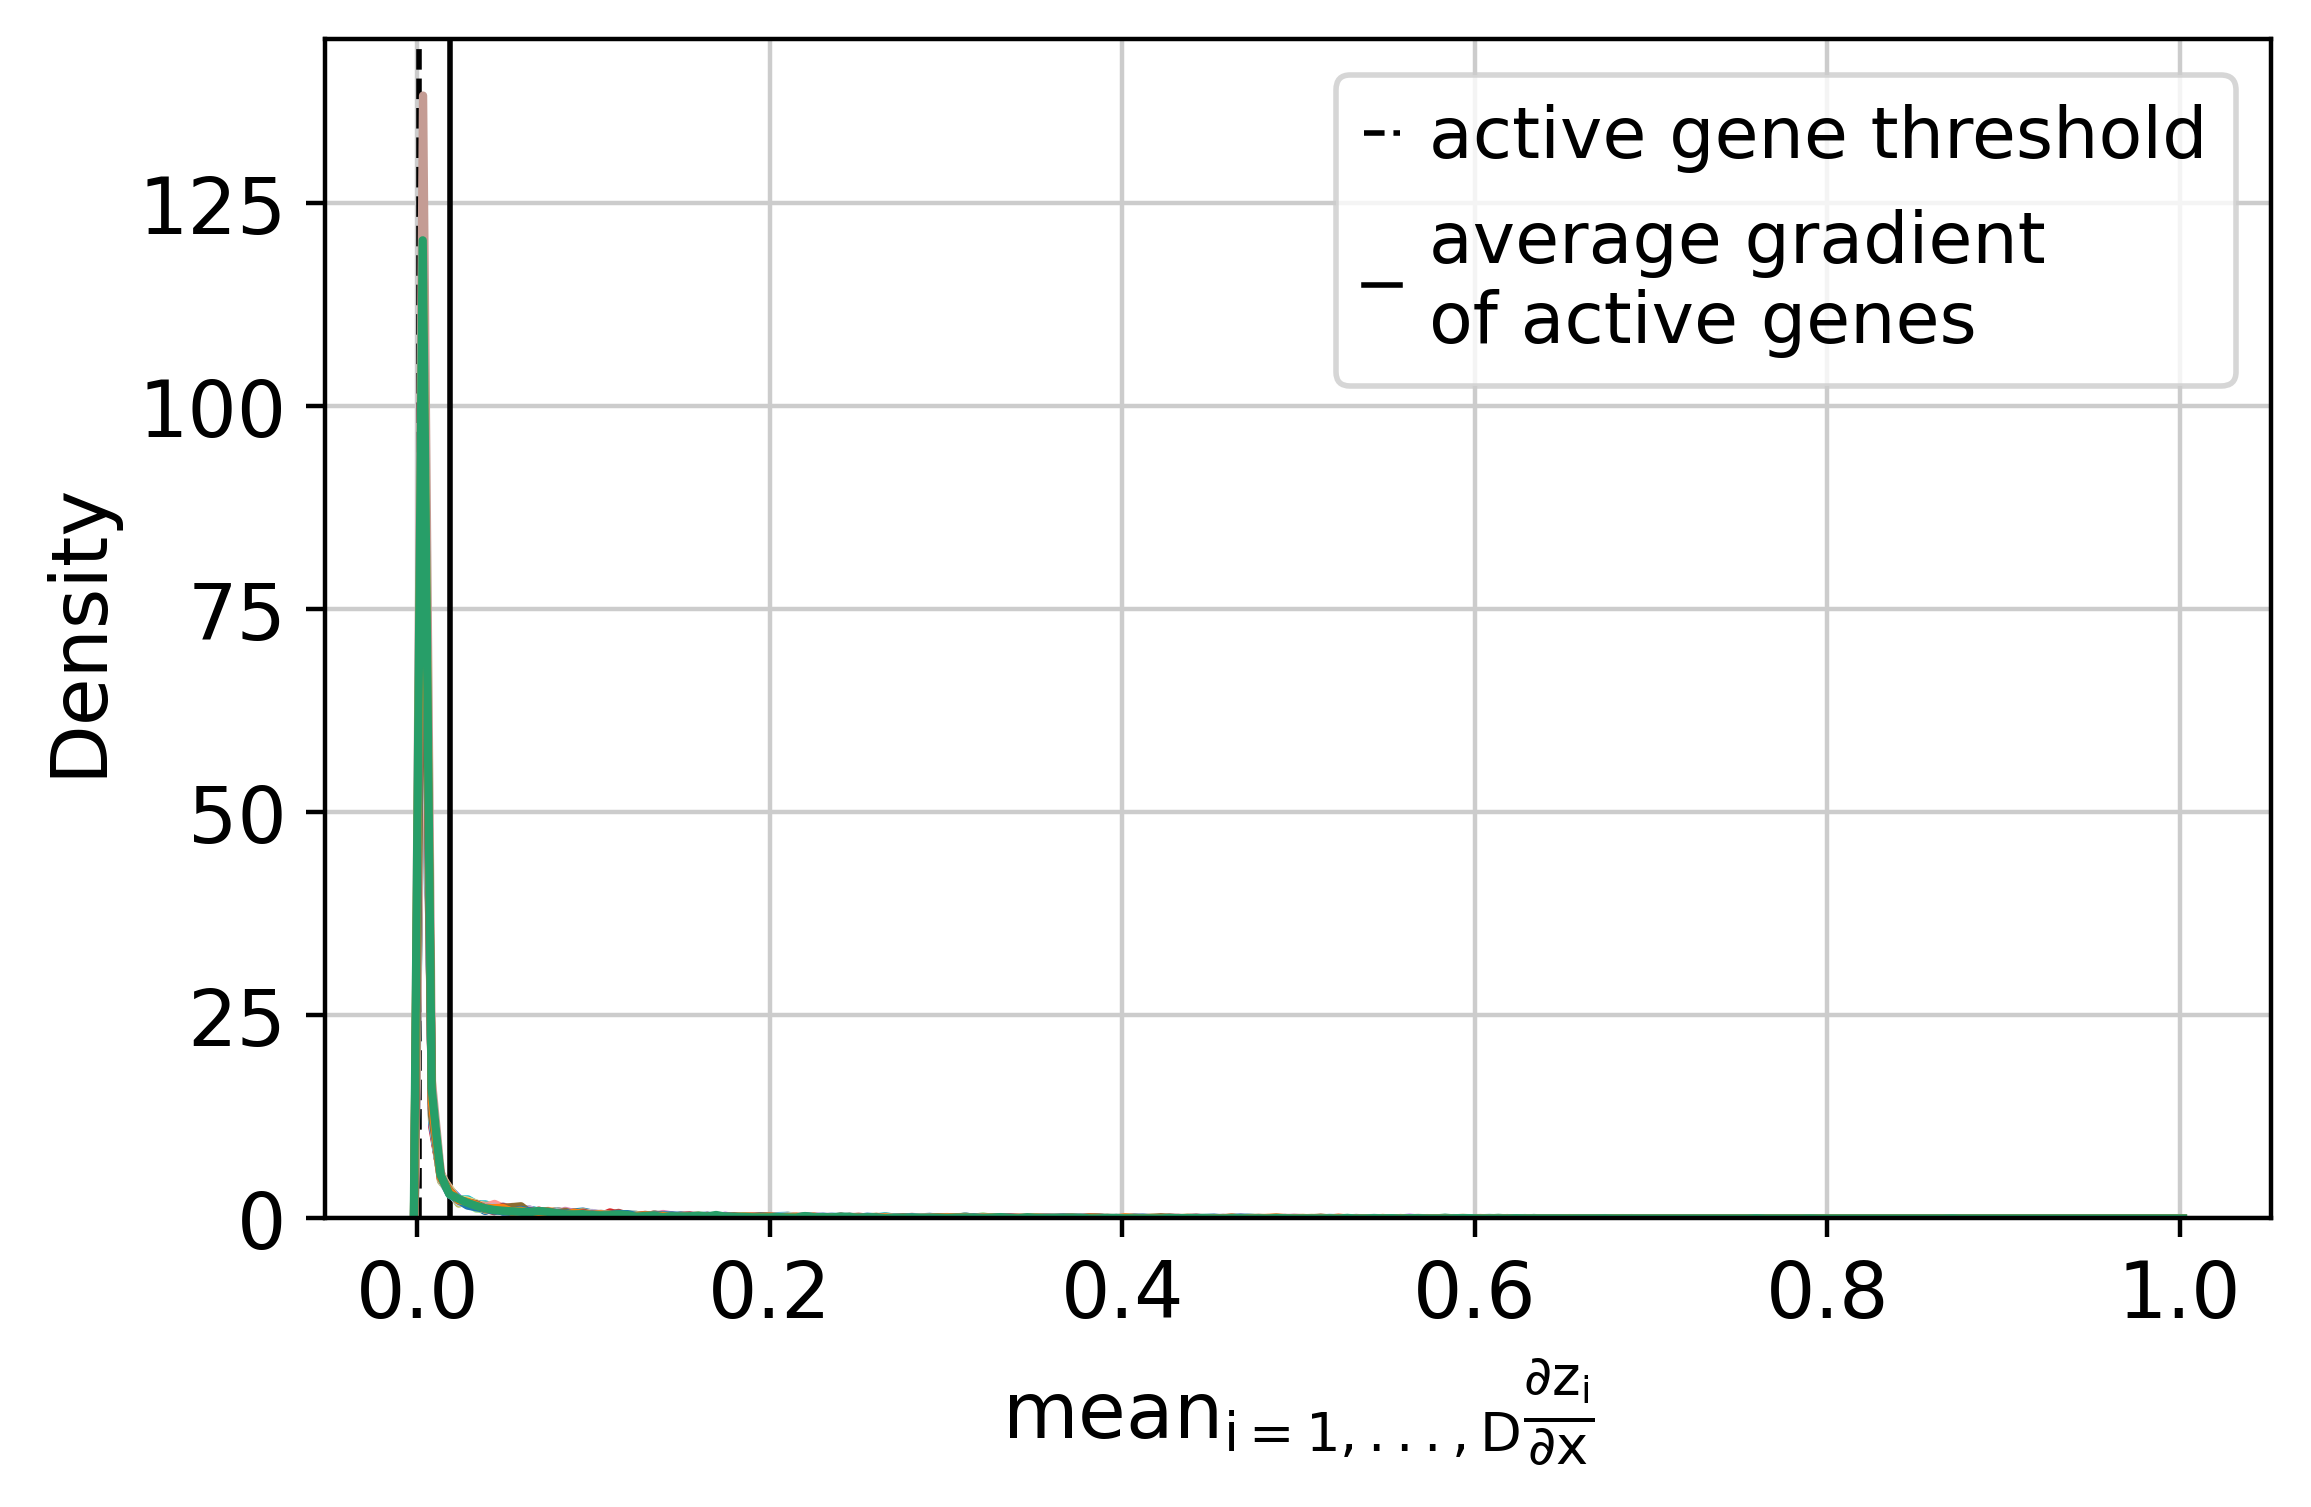

In [11]:
plot_gradient_distr(
    resultspath=dir_human_embedding_linear,
    model_id="embedding_human-esophagus-linear-0.1-0.1_theislab",
    height_fig=4,
    width_fig=6,
    ignore_cache=False,
    normalize=True,
    remove_inactive=False,
    bw=0.01,
    min_cells = 10,
    by_type=True,
    datapath=datadir,
    store_format="h5ad",
    configpath=os.path.join(configpath, "config_human_esophagus.pickle"),
    save=figdir+"gradients_human_esophagus_linear_kde.pdf"
)